# Titanic project

In this project, we are going to explore the famous titanic set, and try to predict if a passenger survived or not.

## Library loading

In [1]:
## Library loading

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import ppscore as pps
import seaborn as sns

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

warnings.filterwarnings("ignore")

Let's start with loading the train and test files for Titanic dataset.

In [2]:
## Reading data from file
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data exploration

To begin with, let's see with what kind of data we are dealing with:

In [3]:
## Basic statistics
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Our target variable is the "Survived" Column, and the rest of the variables contain info about the passengers of Titanic (ticket/fare/sex etc.)

Continuing, we are going to inspect the number of NAs and the percentage per column

In [4]:
#Number of Nas per column
train.isna().sum()   ## Missing values in Age, Cabin and Embarked

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
100*train.isna().mean()   

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

More than 75% of cabin is missing; we will probably drop the variable.

Siimilarly, for the test set: 

In [6]:
test.isna().sum()    ## NA in Age and Cabin 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Plots

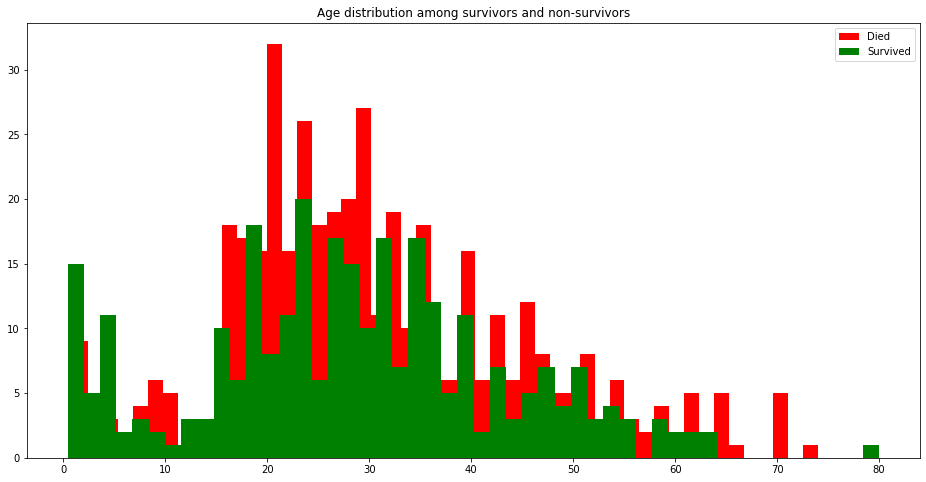

In [8]:
## Basic plots
s0 = train.loc[train.Survived==0,"Age"]
s1 = train.loc[train.Survived==1,"Age"]

plt.figure(figsize=(16,8))
plt.hist(s0,color="red",bins=50,label="Died")
plt.hist(s1,color="green",bins=50,label="Survived")
plt.title("Age distribution among survivors and non-survivors")
plt.legend()

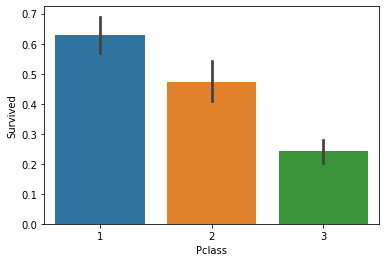

In [9]:
sns.barplot(x='Pclass', y='Survived', data=train)

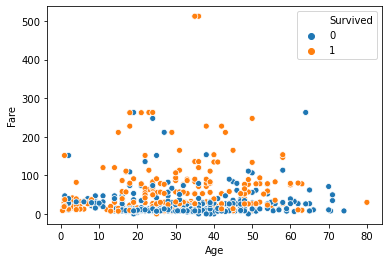

In [10]:
sns.scatterplot(x = "Age", y = "Fare" ,hue="Survived", data = train)

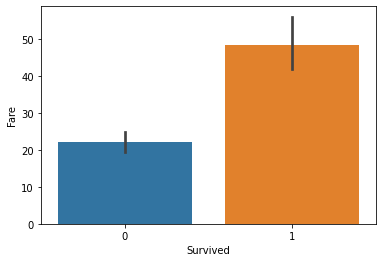

In [11]:
sns.barplot(y = "Fare", x = "Survived", data= train)

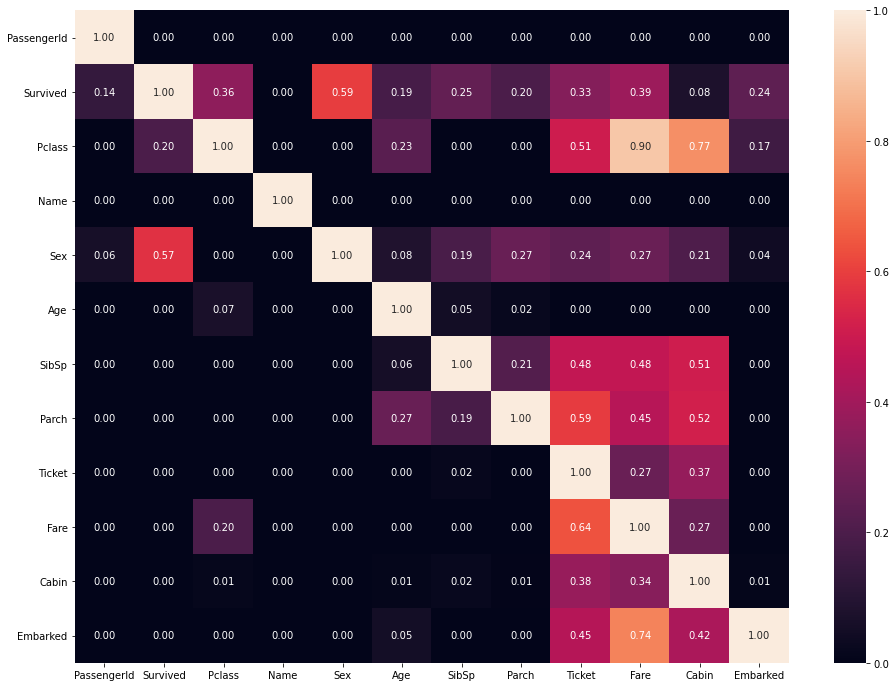

In [12]:
plt.figure(figsize=(16,12))
sns.heatmap(pps.matrix(train),annot=True,fmt=".2f")


Imputating the missing values: Most frequent for categorical data, and mean for the numerical.

In [13]:
imputer = SimpleImputer()
imputer_cat = SimpleImputer(strategy="most_frequent")
train["Age"] = imputer.fit_transform(train[["Age"]])
train["Embarked"]=imputer_cat.fit_transform(train[["Embarked"]])
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [14]:
test['Age']=imputer.fit_transform(test[['Age']])
test['Fare']=imputer.fit_transform(test[['Fare']])
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

### Handling outliers

We are going to build a simple function that takes a a data_frame of features and returns the indices of the observations that have outliers. The outliers are calculated based on Tukeys criterion (Distance>1.5 IQR)

In [15]:
def find_outliers (df,n,features):
    """ The function receives as input a data frame df, a number of outliers per observation, 
    and the features we want to test 
    """
    outliers_index = []          #empty list
    
    for col in features:
        outliers=[]
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = (Q3-Q1)
        Trange = 1.5*IQR
    
        
        outliers = (df[(df[col]<Q1-Trange) | (df[col]>Q3+Trange)].index)
        outliers_index.extend(outliers)
    
    lista = Counter(outliers_index)


    multiple_outliers = list( k for k, v in lista.items() if v > n )
    
    
    return multiple_outliers

In [16]:
outliers_train = find_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [17]:
df_train = train.drop(outliers_train, axis = 0).reset_index(drop=True)

In [18]:
df_train = train

In [19]:
df_test = test

### One-hot encoding for gender and embarked port

In [20]:
sex = pd.get_dummies(df_train["Sex"])
embarked = pd.get_dummies(df_train["Embarked"])

In [21]:
df_train = pd.concat([df_train,sex,embarked],axis=1)

In [22]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0,1,0,0,1
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q,0,1,0,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S,0,1,0,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,0,1,0,0,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S,1,0,0,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NaN,C,1,0,1,0,0


In [23]:
df_train.drop(['Sex','Embarked'],axis=1,inplace=True)

In [24]:
df_train

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,female,male,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",22.000000,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000000,1,0,PC 17599,71.2833,C85,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.000000,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000000,1,0,113803,53.1000,C123,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.000000,0,0,373450,8.0500,NaN,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.000000,0,0,211536,13.0000,NaN,0,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.000000,0,0,112053,30.0000,B42,1,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",29.699118,1,2,W./C. 6607,23.4500,NaN,1,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",26.000000,0,0,111369,30.0000,C148,0,1,1,0,0


In [25]:
sex = pd.get_dummies(df_test["Sex"])
embarked = pd.get_dummies(df_test["Embarked"])

In [26]:
df_test = pd.concat([df_test,sex,embarked],axis=1)

In [27]:
df_test.drop(['Sex','Embarked'],axis=1,inplace=True)

In [28]:
df_test

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,female,male,C,Q,S
0,892,3,"Kelly, Mr. James",34.50000,0,0,330911,7.8292,NaN,0,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.00000,1,0,363272,7.0000,NaN,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",62.00000,0,0,240276,9.6875,NaN,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",27.00000,0,0,315154,8.6625,NaN,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.00000,1,1,3101298,12.2875,NaN,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",30.27259,0,0,A.5. 3236,8.0500,NaN,0,1,0,0,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.00000,0,0,PC 17758,108.9000,C105,1,0,1,0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,1,0,0,1
416,1308,3,"Ware, Mr. Frederick",30.27259,0,0,359309,8.0500,NaN,0,1,0,0,1


In [29]:
def Family_calc(df,col1,col2):
    
    Parents = df[col1]
    Siblings = df[col2]
    Status = []
    
    for items in range(len(df)):
        
        if (Parents[items]+Siblings[items]==0):
            Status.append("Single")
        elif (Parents[items]+Siblings[items]==1):
            Status.append("Double")
        elif (Parents[items]+Siblings[items]>=2 & Parents[items]+Siblings[items]<=3 ):
            Status.append("Family")
        else:
            Status.append("Big Family")
        
    return Status

In [30]:
df_train["Status"]=Family_calc(df_train,"SibSp", "Parch")

In [31]:
df_test["Status"]=Family_calc(df_test,"SibSp", "Parch")

In [32]:
df_test.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,female,male,C,Q,S,Status
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,1,0,1,0,Single
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,1,0,0,0,1,Double
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,1,0,1,0,Single
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,1,0,0,1,Single
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,1,0,0,0,1,Family


In [33]:
Family_train = pd.get_dummies(df_train["Status"],drop_first=True)

In [34]:
df_train = pd.concat([df_train,Family_train],axis=1)

In [35]:
df_train.drop(["Status"],axis=1,inplace=True)

In [36]:
Family_test = pd.get_dummies(df_test["Status"],drop_first=True)

In [37]:
df_test = pd.concat([df_test,Family_test],axis=1)

In [38]:
df_test.drop(["Status"],axis=1,inplace=True)

Lets also drop the ticket, name and cabin that should not affect our predictions.

In [39]:
df_train.drop(["Name","Ticket","Cabin"],axis=1,inplace=True)

In [40]:
df_test.drop(["Name","Ticket","Cabin"],axis=1,inplace=True)

In [41]:
df_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Family,Single
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,1


In [42]:
df_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Family,Single
0,892,3,34.5,0,0,7.8292,0,1,0,1,0,0,1
1,893,3,47.0,1,0,7.0000,1,0,0,0,1,0,0
2,894,2,62.0,0,0,9.6875,0,1,0,1,0,0,1
3,895,3,27.0,0,0,8.6625,0,1,0,0,1,0,1
4,896,3,22.0,1,1,12.2875,1,0,0,0,1,1,0


Train Test Split

In [43]:
df_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Family,Single
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,1


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(df_train.drop(["Survived","PassengerId"],axis=1),
                                                    df_train["Survived"],
                                                    test_size = 0.2)

In [45]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Family,Single
499,3,24.000000,0,0,7.7958,0,1,0,0,1,0,1
546,2,19.000000,1,0,26.0000,1,0,0,0,1,0,0
531,3,29.699118,0,0,7.2292,0,1,1,0,0,0,1
256,1,29.699118,0,0,79.2000,1,0,1,0,0,0,1
868,3,29.699118,0,0,9.5000,0,1,0,0,1,0,1


In [46]:
X1 = X_train

In [47]:
X1=X1[["female","male"]]

In [48]:
logit = LogisticRegression()

In [49]:
fit1 = logit.fit(X1,Y_train)

In [50]:
X2 = X_test

In [51]:
X2 = X2 [["female","male"]]

In [52]:
y_p = fit1.predict(X2)

In [53]:
accuracy_score(y_p,Y_test)

0.7597765363128491

In [54]:
X3 = df_test

In [55]:
X3 = X3[["female","male"]]

In [56]:
y = fit1.predict(X3)

In [57]:
y = pd.DataFrame(y)

In [58]:
y.to_csv("naive.csv")

## Logistic regression

In [59]:
logi = LogisticRegression()

In [60]:
log_fit = logi.fit(X_train,Y_train)

In [61]:
y_pred = pd.DataFrame(log_fit.predict(X_test))

In [62]:
confusion_matrix(y_pred,Y_test)

array([[105,  25],
       [ 10,  39]], dtype=int64)

In [63]:
accuracy_score(Y_test,y_pred)

0.8044692737430168

In [64]:
df_test.drop(["PassengerId"],axis=1,inplace=True)

In [65]:
y_pred = pd.DataFrame(log_fit.predict(df_test))

In [66]:
y_pred.to_csv('predlog.csv')

## Random Forest

In [67]:
rf = RandomForestClassifier(n_estimators=500,max_depth=9,min_samples_split=3)

In [68]:
rf_fit = rf.fit(X_train,Y_train)

In [69]:
y_pred = pd.DataFrame(rf_fit.predict(X_test))

In [70]:
confusion_matrix(y_pred,Y_test)

array([[107,  23],
       [  8,  41]], dtype=int64)

In [71]:
accuracy_score(Y_test,y_pred)

0.8268156424581006

In [72]:
y_pred = pd.DataFrame(rf_fit.predict(df_test))
y_pred_final = pd.DataFrame(test['PassengerId'])
y = pd.concat([y_pred,y_pred_final],axis=1)

In [73]:
y.to_csv("predictions.csv")